# Environment configuration

In [1]:
import findspark
findspark.init('/Users/lmh/Programs/spark-2.2.0-bin-hadoop2.7')
from pyspark.sql import SparkSession 
from pyspark.sql import Row
from pyspark.sql import SQLContext
from pyspark.sql.functions import *
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from matplotlib import pyplot as plt
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(sc)

# Load data from the file

In [2]:
rdd = sc.textFile('ratings_Sports_and_Outdoors.csv')
rdd = rdd.map(lambda x: x.split(','))
rdd.take(10)

[[u'A3PMSRCL80KSA1', u'0000031852', u'4.0', u'1388275200'],
 [u'A1SNLWGLFXD70K', u'0000031852', u'4.0', u'1392940800'],
 [u'A1KJ4CVG87QW09', u'0000031852', u'4.0', u'1389657600'],
 [u'AA9ITO6ZLZW6', u'0000031852', u'5.0', u'1399507200'],
 [u'APJ5ULJ1RMZ4', u'0000031852', u'1.0', u'1398556800'],
 [u'A2PAVURT4NOHE1', u'0000031852', u'5.0', u'1388361600'],
 [u'A3URQ0LXLV46E9', u'0000031852', u'4.0', u'1400544000'],
 [u'A2681T699HV6H1', u'0000031895', u'4.0', u'1384905600'],
 [u'A2EPSZKEG06QZE', u'0000031895', u'2.0', u'1396224000'],
 [u'A23K73OVXJ04EG', u'0000031895', u'5.0', u'1391212800']]

# Label users and items
## The function merges 2 dictionaries

In [3]:
def mergedic(x, y):
    x.update(y)
    return x

## Create RDDs

In [4]:
def count_plot(x):
    value = map(lambda a: a[0], x)
    label = map(lambda a: a[1], x)
    plt.barh(range(len(value)), value, color = 'blue')
    plt.yticks(range(len(value)), label)
    plt.show()

In [5]:
user = rdd.map(lambda x: x[0])
num_user = user.distinct().count()
print num_user
#user.take(10)

1990521


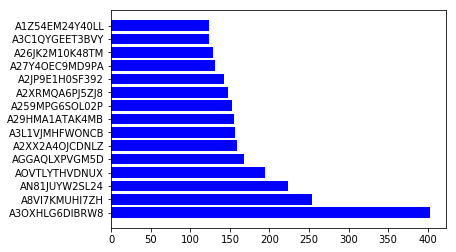

In [6]:
user_rnum_count = user.map(lambda x: (x, 1))\
                  .reduceByKey(lambda x, y: x + y)\
                  .map(lambda x: (x[1], x[0]))\
                  .sortByKey(False)
count_plot(user_rnum_count.take(15))

In [7]:
item = rdd.map(lambda x: x[1])
num_item = item.distinct().count()
print num_item
#item.take(10)

478898


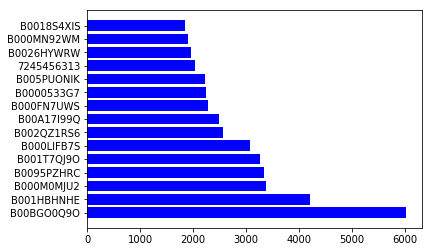

In [8]:
item_rnum_count = item.map(lambda x: (x, 1))\
                  .reduceByKey(lambda x, y: x + y)\
                  .map(lambda x: (x[1], x[0]))\
                  .sortByKey(False)
count_plot(item_rnum_count.take(15))

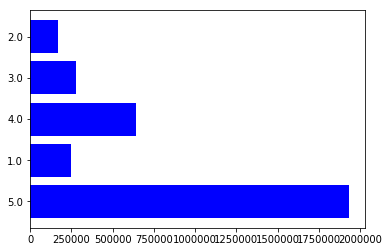

In [9]:
rating_count = rdd.map(lambda x: (x[2], 1))\
               .reduceByKey(lambda x, y: x + y)\
               .map(lambda x: (x[1], x[0]))
#rating_count.take()
count_plot(rating_count.collect())

In [11]:
unrdd = sc.parallelize(range(1, num_user + 1))
inrdd = sc.parallelize(range(1, num_item + 1))
pair = unrdd.cartesian(inrdd)
#pair.take(10)

## Create dictionaries

In [10]:
userd = user.distinct().zipWithIndex()
userd = userd.map(lambda x: {x[0]: x[1] + 1})
user_dic = userd.reduce(mergedic)

In [11]:
itemd = item.distinct().zipWithIndex()
itemd = itemd.map(lambda x: {x[0]: x[1] + 1})
item_dic = itemd.reduce(mergedic)

In [12]:
cb = rdd.map(lambda (user, item, rating, timestamp): [user, item, rating, user_dic[user], item_dic[item]])
#cb.take(5)

# Create dataframes

In [13]:
cbrdd = cb.map(lambda x: Row(username = x[0],
                             itemname = x[1],
                             rating = float(x[2]),
                             userid = int(x[3]),
                             itemid = int(x[4])))
#cbrdd.take(5)

In [16]:
df = spark.createDataFrame(cbrdd)
df.repartition(1).write.csv('tempcsv', sep = ',')

In [17]:
userdf = df.select('userid', 'username').dropDuplicates()
#userdf.show(5)

In [18]:
itemdf = df.select('itemid', 'itemname').dropDuplicates()
#itemdf.show(5)

In [19]:
pairdd = pair.map(lambda x: Row(userid = x[0],
                             itemid = x[1]))
uimatrix = spark.createDataFrame(pairdd)
#uimatrix.show(5)

In [20]:
uimatrix = uimatrix.join(userdf, userdf.userid == uimatrix.userid).drop(userdf.userid)
uimatrix = uimatrix.join(itemdf, itemdf.itemid == uimatrix.itemid).drop(itemdf.itemid)
#uimatrix.show()

# Collaborative Filtering with ALS

## Construct model

In [20]:
#als = ALS(maxIter = 5, regParam = 0.01, implicitPrefs = False, 
#          userCol = "userid", itemCol="itemid", ratingCol="rating",
#          coldStartStrategy="drop")
#model = als.fit(df)

## Make prediction

In [21]:
#df_c = df
#pred = model.transform(df_c)
#pred.show()

## Evaluate ALS with RMSE

In [22]:
#evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
#                                predictionCol="prediction")
#rmse = evaluator.evaluate(pred)
#print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 0.130707860234


## Recommend users

In [23]:
#userRecs = model.recommendForAllUsers(3)
#userRecs.show(10, False)

## Recommend items

In [24]:
#itemRecs = model.recommendForAllItems(1)
#itemRecs.show(10, False)

# Get the mean value of each user

In [26]:
pred1 = model.transform(uimatrix)
#pred1.show()

In [23]:
newdf2 = df.groupby('userid').agg({'rating': 'mean'})
newdf2.show()

AnalysisException: u'Cannot resolve column name "rating" among (userid, avg(rating));'

In [27]:
newdf5 = pred1.join(newdf2, pred1.userid == newdf2.userid).drop(newdf2.userid)
newdf5 = newdf5.withColumnRenamed('avg(rating)', 'mean')
#newdf5.show()

In [28]:
newdf6 = newdf5.withColumn('difference', newdf5.prediction - newdf5.mean)
#newdf6.show()

In [29]:
newdf7 = newdf6.groupby('itemid').agg({'difference': 'sum'})
#newdf7.show()

In [30]:
newdf8 = newdf6.join(newdf7, newdf6.itemid == newdf7.itemid).drop(newdf7.itemid)
newdf8 = newdf8.withColumnRenamed('sum(difference)', 'sum').drop('difference')
#newdf8.show()

In [31]:
k = 0.001
newdf9 = newdf8.withColumn('result', newdf8.mean + k * newdf8.sum).drop('sum')
newdf9.show()

+------+--------------+----------+----------+----+------+-----------------+
|userid|      username|  itemname|prediction|mean|itemid|           result|
+------+--------------+----------+----------+----+------+-----------------+
|    26|A3S8IGM1KJHGPK|0002007827| 1.6495903| 1.0|    26|5.579969124305124|
|    29|A1ARJ1DEQS41FF|0002007827| 1.6495903| 1.0|    26|5.579969124305124|
|   474|A2L7Z3FH4MSWYW|0002007827|  8.247953| 5.0|    26|9.579969124305123|
|   964| A8HHJP5GED6YB|0002007827|  6.598361| 4.0|    26|8.579969124305123|
|  1677| AG7R3MMF8QLDT|0002007827|-0.1670794| 4.0|    26|8.579969124305123|
|  1697|A3JVEZEL9C2DM5|0002007827|  3.674696| 5.0|    26|9.579969124305123|
|  1806| A62MJBV7BCVP5|0002007827| 2.2048175| 3.0|    26|7.579969124305124|
|  1950|A3FMRJVCRR11YQ|0002007827| 4.9487715| 3.0|    26|7.579969124305124|
|  2040|A20ATMFBVIHS21|0002007827| 1.4198892| 5.0|    26|9.579969124305123|
|  2214| AEYT8DBFWEAUJ|0002007827|  6.598361| 4.0|    26|8.579969124305123|
|  2250|A3VL